/home/coding/ml-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-28 12:02:18.503740: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-28 12:02:19.581872: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loading checkpoint shards: 100%|██████████| 3/3 [00:43<00:00, 14.59s/it]


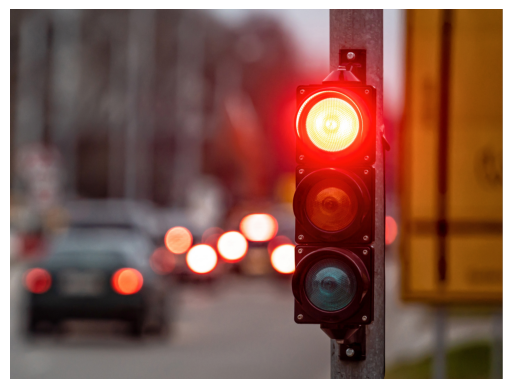

Context ——> a red light is on a street corner.
Quotation ——> In the heart of the city, where the rhythm of life pulses relentlessly, a solitary beacon of crimson light stands guard, casting an ethereal glow on the cobblestones, reminding us that even in the midst of chaos, there is a semblance of order, a testament to the enduring spirit of humanity.


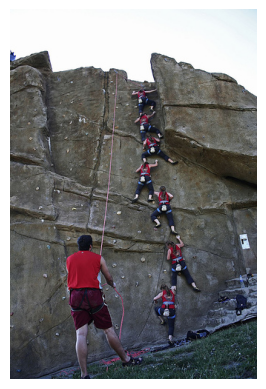

Context ——> a group of climbers are climbing up a rock face.
Quotation ——> Reach for the summit, not for the applause. The climb, not the arrival, is the true reward.


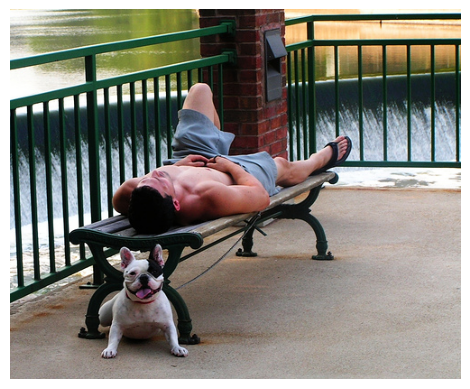

Context ——> a man is lying on a bench with his dog.
Quotation ——> In the quiet moments, when the world seems to pause, there is a bond that transcends time and space. A man and his dog, two souls intertwined, sharing a moment of peace and companionship.


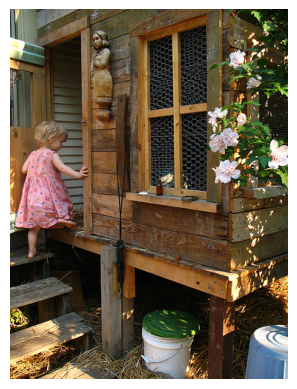

Context ——> a little girl in a pink dress is climbing into a wooden playhouse.
Quotation ——> In the heart of childhood, dreams take flight, as innocence weaves tales of adventure, and the world transforms into a playhouse of endless possibilities.


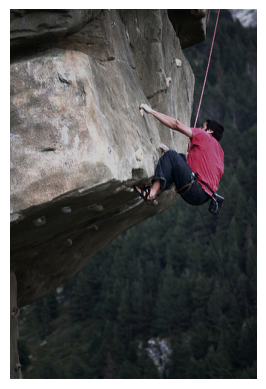

Context ——> a man in a red shirt is rock climbing.
Quotation ——> Reach for the sky, scale new heights, and never lose sight of the red-shirted warrior within you, for it is the indomitable spirit that propels us to conquer our own personal mountains.


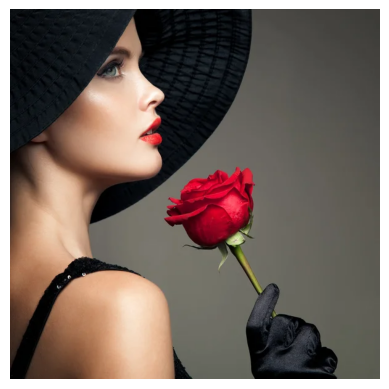

Context ——> a woman in a black hat holding a red rose.
Quotation ——> In the quiet hues of monochrome, a woman in black emerges, her hat a silhouette against the world. In her hand, a crimson rose, a symbol of passion and love, blooms. 'Life is a canvas, painted with the hues of our choices, and the rose, a testament to the beauty that lies in the choices we make.'


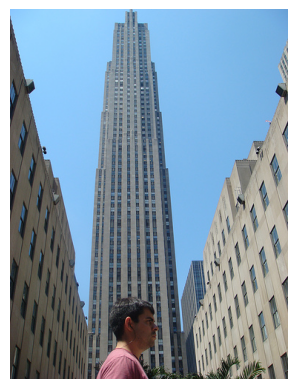

Context ——> a man stands in front of a skyscraper.
Quotation ——> In the grandeur of steel and glass, a man finds his own reflection, a testament to the indomitable spirit that dares to reach for the skies.


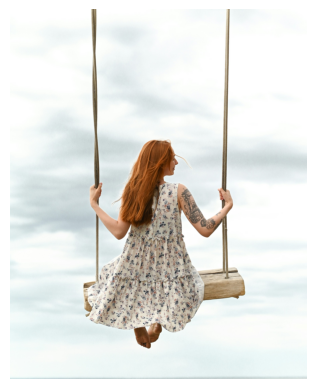

Context ——> a girl on a swing.
Quotation ——> In the rhythm of the wind, she found her freedom, swinging gently into the boundless skies, a testament to the joy of youth and the magic of childhood.


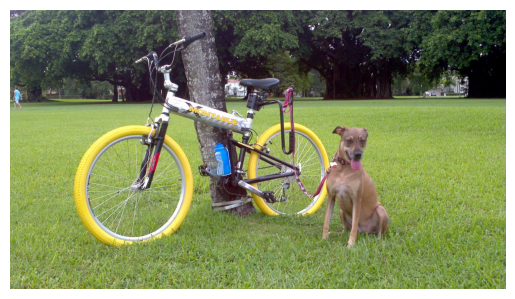

Context ——> a brown dog is sitting next to a yellow bicycle in the grass.
Quotation ——> In the verdant embrace of nature, a loyal companion and a symbol of freedom intertwine, their stories etched in the golden hues of a timeless moment.


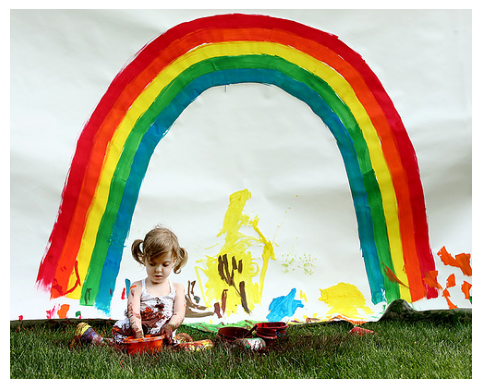

Context ——> a little girl sits in front of a painted rainbow.
Quotation ——> In the vibrant hues of a child's imagination, dreams take flight, and the world transforms into a canvas of endless possibilities. Where the rainbow meets the earth, a little girl paints her dreams, bridging the gap between reality and fantasy, reminding us all that the most magical places are those found within our hearts.


In [1]:
import os
import re
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import matplotlib.pyplot as plt
from transformers import BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer
import torch

# Set paths
checkpoint_dir = "/home/coding/AI-Captioning/notebook/blip-finetuned/checkpoint-6069"
test_image_folder = "/home/coding/AI-Captioning/data/new_data/"
model_path = "/home/coding/AI-Captioning/notebook/models/mistral_models/7B-Instruct-v0.3/"
# Setup device
device = "cuda" if torch.cuda.is_available() else "cpu"
# Load tokenizer for Mistral model
tokenizer = AutoTokenizer.from_pretrained(model_path)
# Setup 4-bit quantization config with CPU offload for heavy parts
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    llm_int8_enable_fp32_cpu_offload=True,
    bnb_4bit_compute_dtype=torch.float16,  # match GPU dtype
)

model_Mistral = AutoModelForCausalLM.from_pretrained(
    model_path,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,  # disable to avoid partial CPU offload confusion
)

# Load processor and model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained(checkpoint_dir).to(device)
model.eval()

# Collect first 5 test images
image_paths = sorted([
    os.path.join(test_image_folder, img)
    for img in os.listdir(test_image_folder)
    if img.endswith(('.jpg', '.png', '.jpeg'))
])[:10]

# Caption each image
for img_path in image_paths:
    image = Image.open(img_path).convert("RGB")
    
    # Show image
    plt.imshow(image)
    plt.axis("off")
    # plt.title(f"Image: {os.path.basename(img_path)}")
    plt.show()

    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        output = model.generate(**inputs, max_length=30, num_beams=5)

    raw_caption = processor.decode(output[0], skip_special_tokens=True)
    caption = raw_caption.strip().split(".")[0].replace("[", "").replace("'", "").replace(",", "").strip() + "."

    prompt = f"I have an image in which {caption}Generate a quotation around it."
    inputs = tokenizer(prompt, return_tensors="pt").to(model_Mistral.device)

    outputs = model_Mistral.generate(**inputs, max_new_tokens=500, pad_token_id=tokenizer.eos_token_id)
    Quotetion = tokenizer.decode(outputs[0], skip_special_tokens=True)

    quote = re.search(r'"(.*?)"', Quotetion, re.DOTALL)
    if quote:
        final_quote = (quote.group(1))
    else:
        final_quote = ("No quote generated.")

    print(f"Context ——> {caption}")
    print(f"Quotation ——> {final_quote}")